In [4]:
%matplotlib inline

In [13]:
### Import Packages

import matplotlib.pyplot as plt
import numpy as np
import starry
import pandas as pd
from glob import glob
import os
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import theano
import theano.tensor as tt
import theano.sparse as ts
import math

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

###### Options for rotation period : "r25", "r5", "r10" & "r20"
###### Options for inclination angle : $5n\vert\forall n\in [0:18]$ 
###### NOTE: 0 degrees in the filenames equates to equator on, while in Starry 90 is equator on

In [6]:
### Variables to load in files and generate maps

rotation_period_file = "r5"
rotation_period = 5
inc_angle = 20
ydeg = 5
random_seed = 5

In [48]:
#### create a file name variable

filename = "lightcurve_bd/totalflux_"+ rotation_period_file + "_" + str(inc_angle) + "degree.txt"

In [52]:
filename[14:-4]

'totalflux_r5_20degree'

In [55]:
### Create a new directory for each object if it doesn't already exist

if os.path.exists("XianyuMaps/"+filename[14:-4])==False:
    os.mkdir("XianyuMaps/"+filename[14:-4])
else:
    pass

In [59]:
### Defining function to generate maps

def SurfaceMaps(rotation_period_file,rotaiton_period,inc_angle,ydeg,filename,random_seed):
    ### -LOADING THE FILE, SETTING FLUX AND TIME- ###
    file = np.loadtxt(filename) # load the txt file
    flux = file[1] # Obtain flux
    flux = flux/np.median(flux) # Normalize flux
    time =  file[0] # Obtain time
    sigma=0.001 # Set error
    projection_type = ["moll", "ortho", 'rect'] # array with projection types
    ### -STARRY SURFACE MAPS- ###
    map = starry.Map(ydeg=ydeg, reflected=False)
    map.obl = 0
    map.inc = inc_angle
    map.set_data(flux , C=sigma ** 2)
    mu = np.empty(map.Ny)
    mu[0] = 1
    mu[1:] = 0
    L = np.empty(map.Ny)
    L[0] = 1e0
    L[1:] = 1e-5
    map.set_prior(L=L)
    nrot=max(time)/rotation_period
    npts = len(time)
    theta = np.linspace(0, 360 * nrot, npts)
    kwargs = dict(theta=theta)
    mu, cho_cov = map.solve(**kwargs)
    for projection in projection_type:
        map.show(colorbar=True, projection=projection, file="XianyuMaps/" + filename[14:-4] + "/"+ projection + "_map.jpg")
    ### -RANDOM MAPS- ###
    for random in range(random_seed):
        for projection in projection_type:
            np.random.seed(random)
            map.draw()
            map.show(colorbar=True, projection=projection, file="XianyuMaps/" + filename[14:-4] + "/" + projection + str(random) + "_map.jpg")
    ### -PLOTTING -###
    fig, ax = plt.subplots(1, figsize=(12, 4))
    plt.plot(time, flux,color="blue")
    plt.plot(time, map.flux(**kwargs),color="red")
    ax.set_xlabel("Time (hr)", fontsize=18)
    ax.set_ylabel("Normalized flux", fontsize=18);
    ax.legend()
    plt.savefig("XianyuMaps/" + filename[14:-4] + "/StarryFit.jpg")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


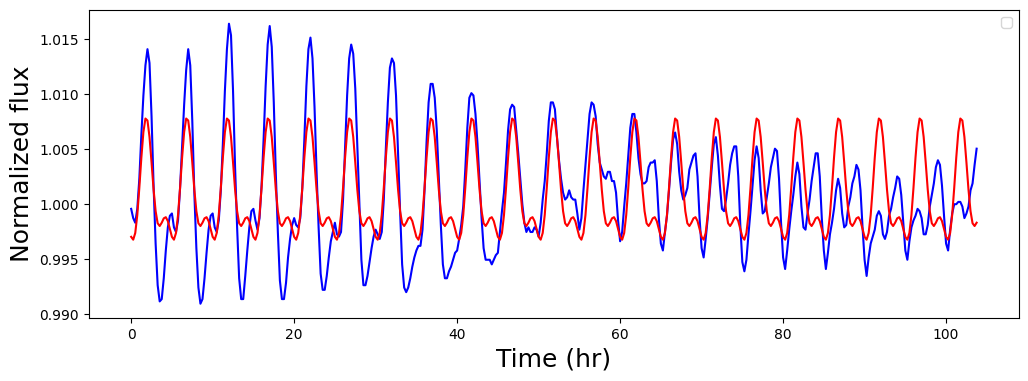

In [60]:
### Apply SurfaceMaps function

SurfaceMaps(rotation_period_file,rotation_period,inc_angle,ydeg,filename,random_seed)

##### Split each individual rotation then fit

In [70]:
def RotationSpliter(rotation_period,rotation_period_file,inc_angle,ydeg,filename):
    n=1 # Counter for each individual rotation, add 1 when each rotation is fit. Start at first rotation
    new_light_curve = [] # empty list for storing the new light curve from the split rotation
    starry_light_curve_fits = [] # empty list for storing Starry fits
    new_time = [] # empty list for storing the time values for new fitted light curve
    start_index = 0 # have a variable for the index of the start of each rotation
    end_index = 0 # have a variable for the index of the end of each rotation
    end_indices = [] # store values of end indices to mark on plot
    file = np.loadtxt(filename) # load the txt file
    flux = file[1] # Obtain flux
    flux = flux/np.median(flux) # Normalize flux
    time =  file[0] # Obtain time
    full_rotations = math.floor(time[-1]/rotation_period)
    sigma=0.001 # Set error
    projection_type = ["moll","ortho", 'rect'] # array with projection types
    for point in range(len(flux)): # stay within the light curve array
        if n <= full_rotations: # work within number of full rotations
            if time[point] == rotation_period*n: # check if the current position in the flux array is within the current rotation number
                if n==1: # check if the current rotation is the first one
                    n+=1 # increase number of rotations to 2
                    end_index=point+1 # get the index for the last point of the current rotation
                    new_light_curve.append([flux[0:end_index]]) # append light curve of current rotation to list
                    new_time.append([time[0:end_index]]) # append the time array of current rotation to list
                    end_indices.append(end_index) # append index of last point in light curve to a list
                else:
                    n+=1
                    start_index = end_index # make the starting index for the next rotation
                    end_index += 1 # get the index for the last point of the current rotation
                    new_light_curve.append([flux[start_index:end_index]]) # append light curve of current rotation to list
                    new_time.append([time[start_index:end_index]]) # append the time array of current rotation to list
                    end_indices.append(end_index) # append index of last point in light curve to a list
    rotation_start_points = []
    rotation_start_time = []
    for index in end_indices:
        rotation_start_points.append(flux[index])
        rotation_start_time.append(time[index])
    ### -FITTING EACH INDIVIDUAL ROTATION- ###
    for light_curve in range(len(new_light_curve)):
        map = starry.Map(ydeg=ydeg, reflected=False)
        map.obl = 0
        map.inc = inc_angle
        map.set_data(new_light_curve[light_curve][0], C=0.001** 2)
        ## Other map parameters
        mu = np.empty(map.Ny)
        mu[0] = 1
        mu[1:] = 0
        L = np.empty(map.Ny)
        L[0] = 1e0
        L[1:] = 1e-5
        map.set_prior(L=L)
        nrot=1
        npts = len(new_time[light_curve][0])
        theta = np.linspace(0, 360 * nrot, npts)
        kwargs = dict(theta=theta)
        mu, cho_cov = map.solve(**kwargs)
        starry_light_curve_fits.append([map.flux(**kwargs)])
        for projection in projection_type:
            map.show(colorbar=True,figsize=(10,10),projection=projection, file="XianyuMaps/"+filename[14:-4] +"/" + projection + "_"+str(light_curve)+ "rotation_" +str(ydeg) +"ydeg_map.jpg")
    ### -PLOTTING INDIVIDUAL ROTATION FITS- ###
    for i in range(len(new_time)):
        fig, ax = plt.subplots(1,figsize=(12, 4))
        plt.title(filename[14:-4] + " ydeg "+str(ydeg) + " Starry fits Rotation " + str(i+1))
        plt.plot(new_time[i][0],starry_light_curve_fits[i][0],linewidth=5,color="red")
        plt.savefig("XianyuMaps/"+filename[14:-4] +"/"+"_ydeg"+str(ydeg)+" Starry_Fits"+str(i+1)+".jpg")
    ### -PLOTTING FULL LIGHT CURVE WITH INDIVIDUAL ROTATION FITS- ###
    fig, ax = plt.subplots(1,figsize=(12, 4))
    plt.title(filename[:-4] + " ydeg "+str(ydeg) + " Starry fits")
    plt.plot(rotation_start_time, rotation_start_points, c="orangered")
    plt.plot(time, flux,label="Data",linestyle="none",marker="o",color="blue")
    plt.plot(new_time[0][0], starry_light_curve_fits[0][0],label="Starry fit",linewidth=5,color="red")
    for i in range(len(new_time)):
        plt.plot(new_time[i][0], starry_light_curve_fits[i][0],linewidth=5,color="red")
    plt.legend(prop={'size': 20})
    ax.set_xlabel("Time (days)", fontsize=20)
    ax.set_ylabel("Flux", fontsize=20)
    plt.savefig("XianyuMaps/"+filename[14:-4] +"/"+"_ydeg"+str(ydeg)+" Starry_Fits.jpg")

/var/folders/r2/xv00hkdx2rz_87ckk29tm9000000gn/T/ipykernel_30262/2022273971.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,figsize=(12, 4))


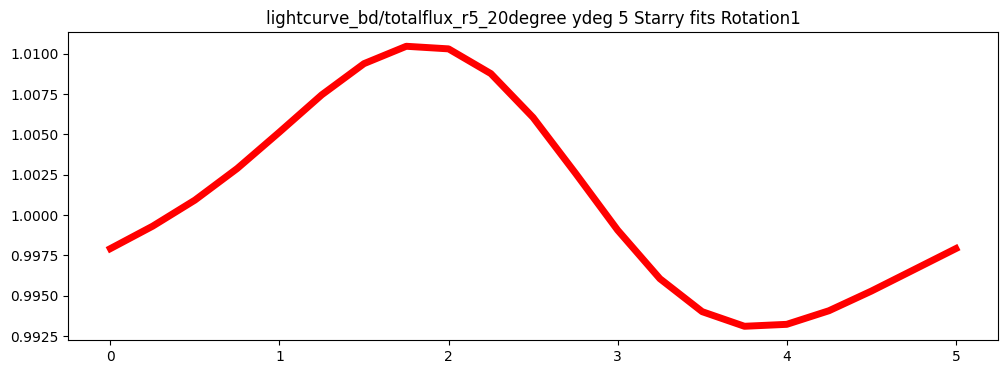

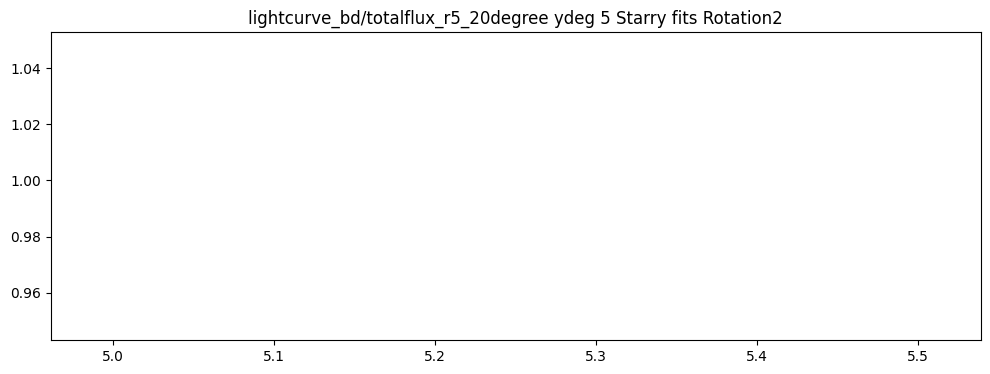

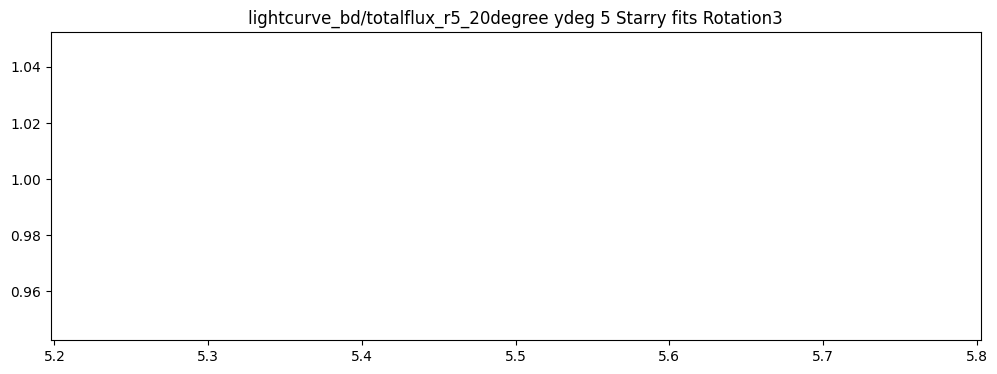

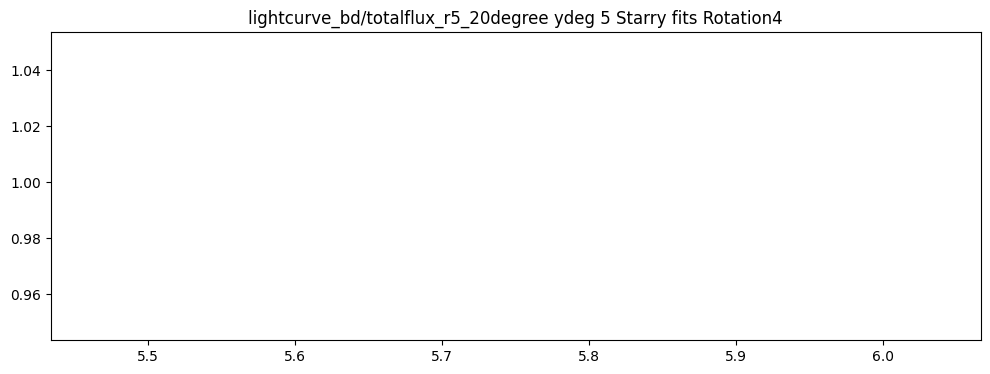

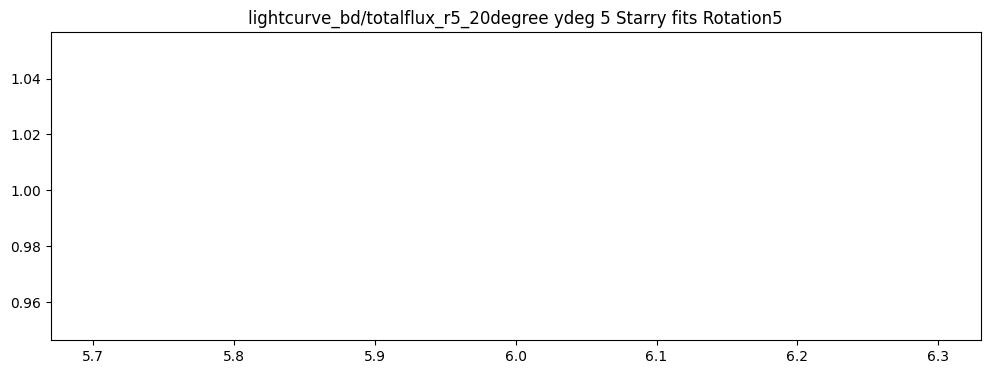

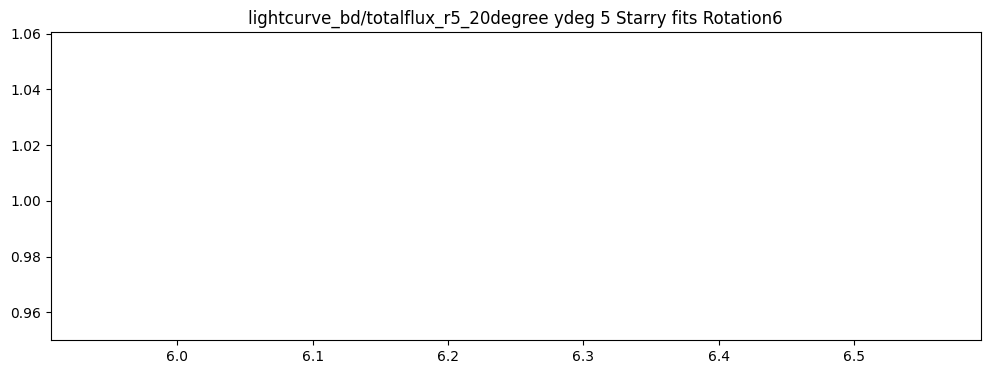

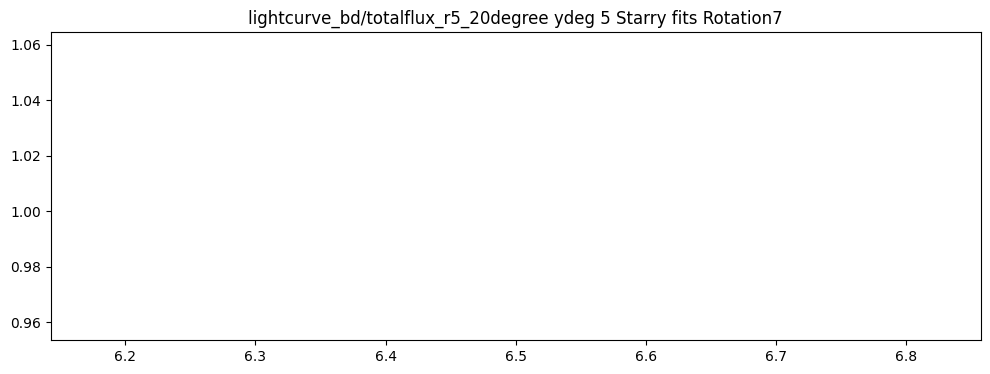

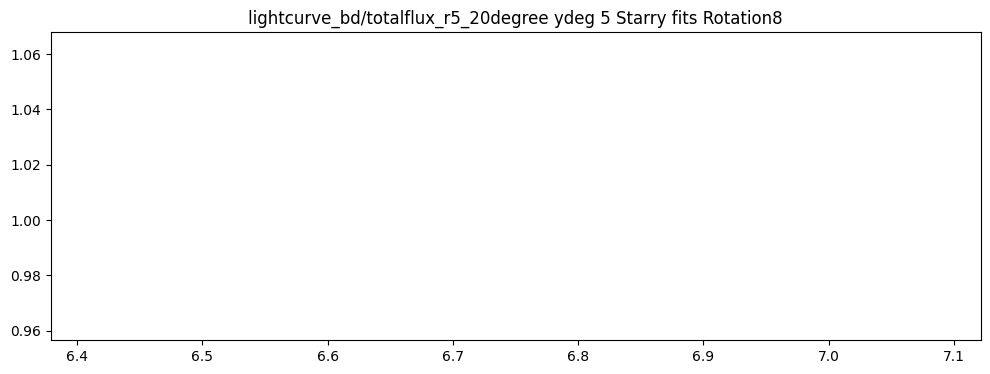

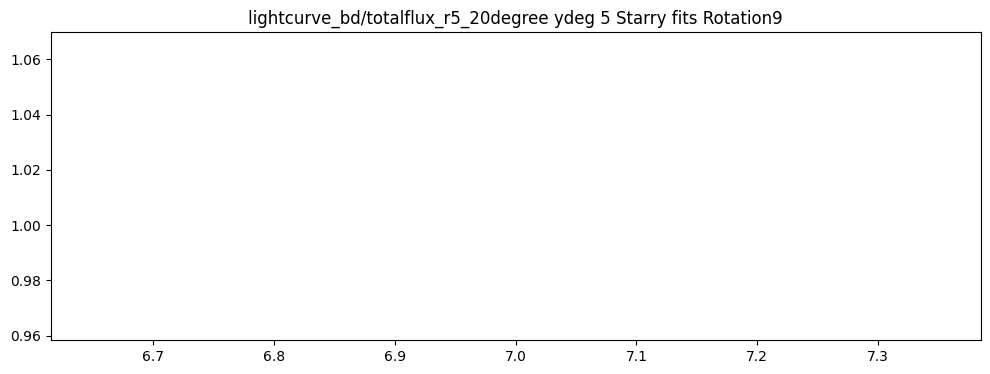

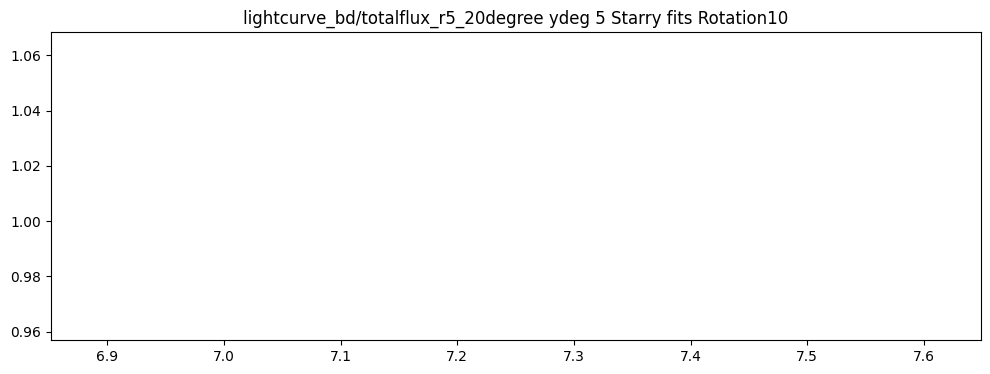

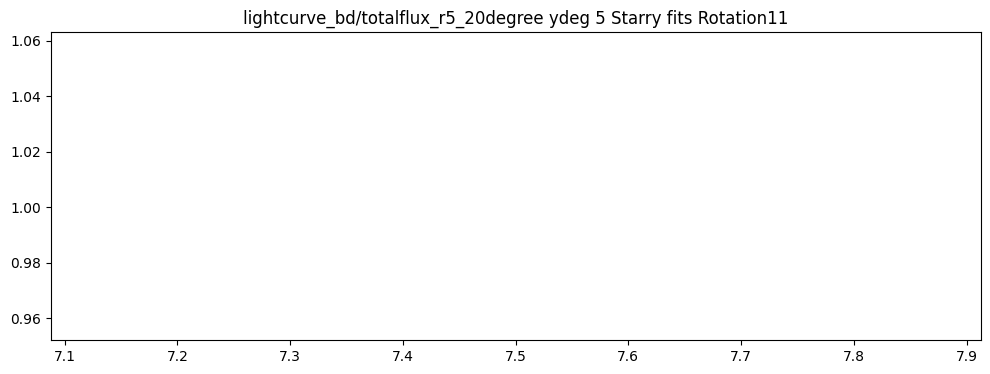

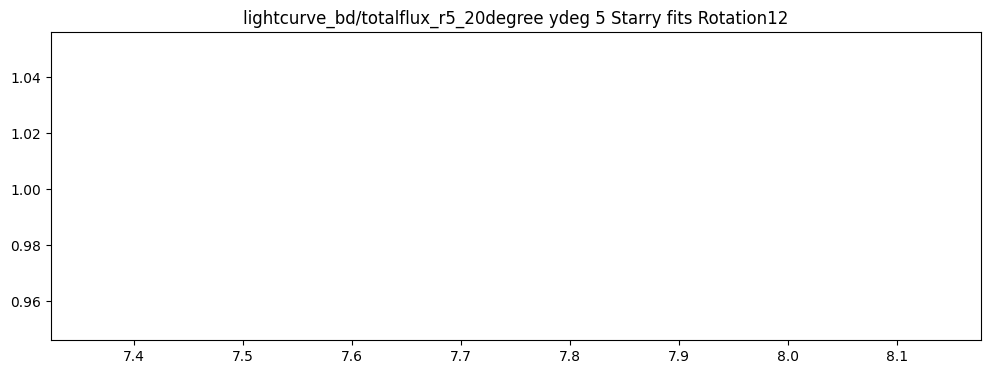

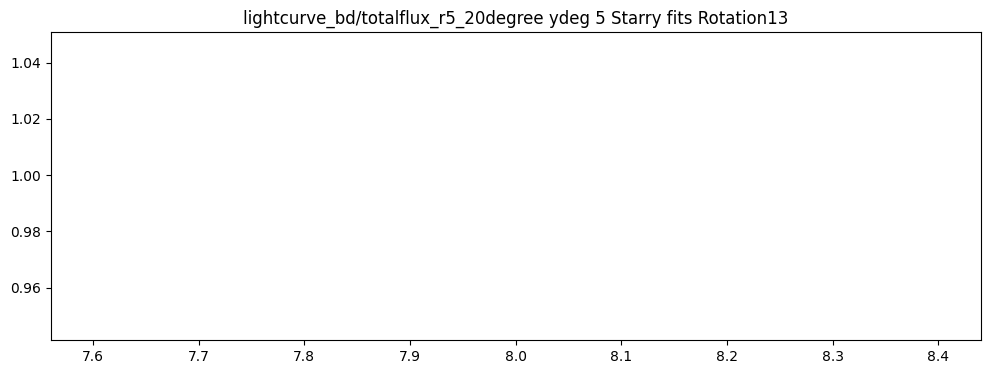

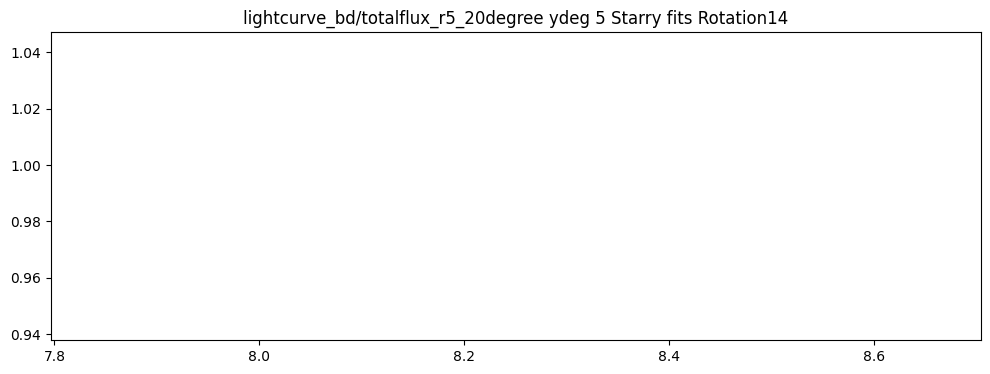

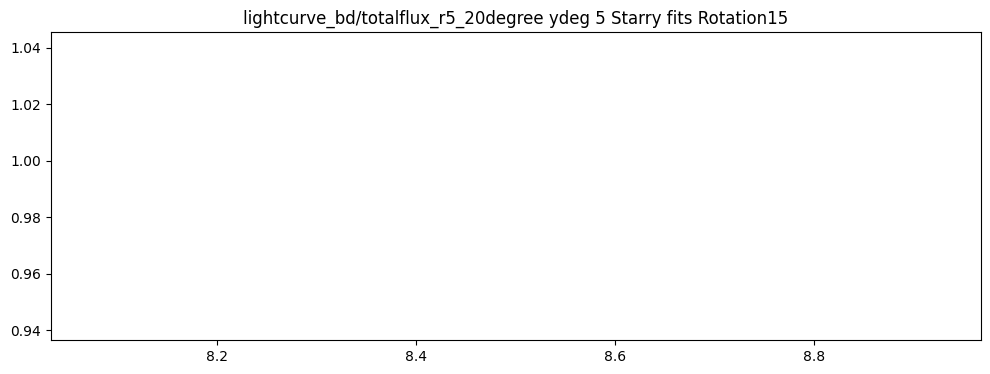

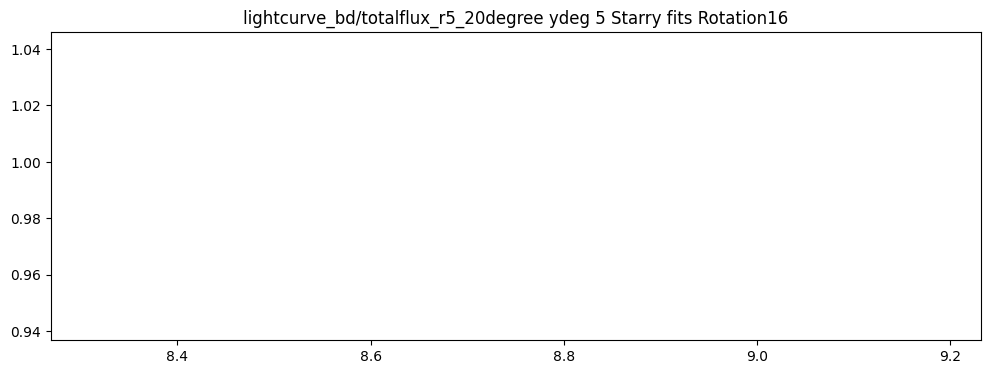

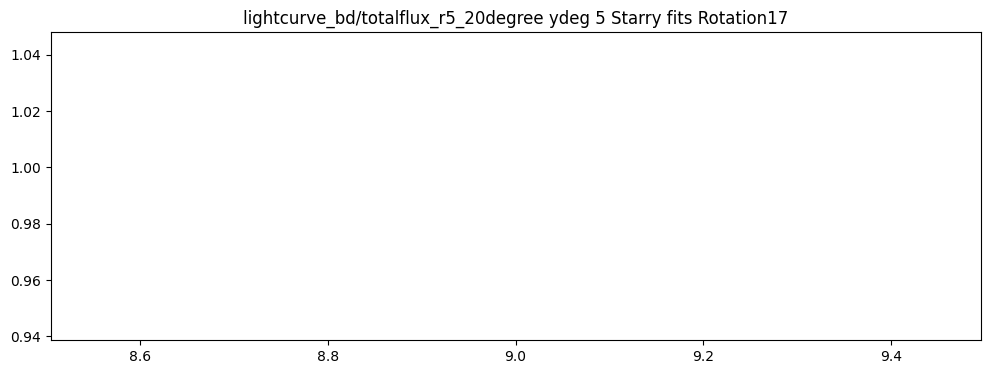

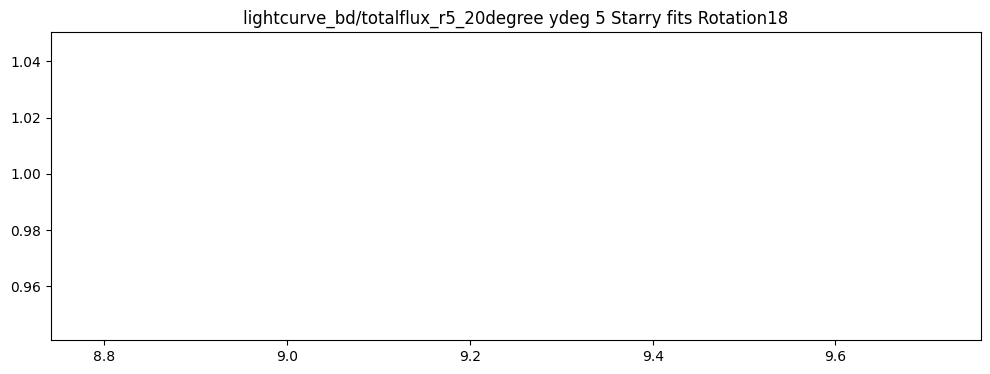

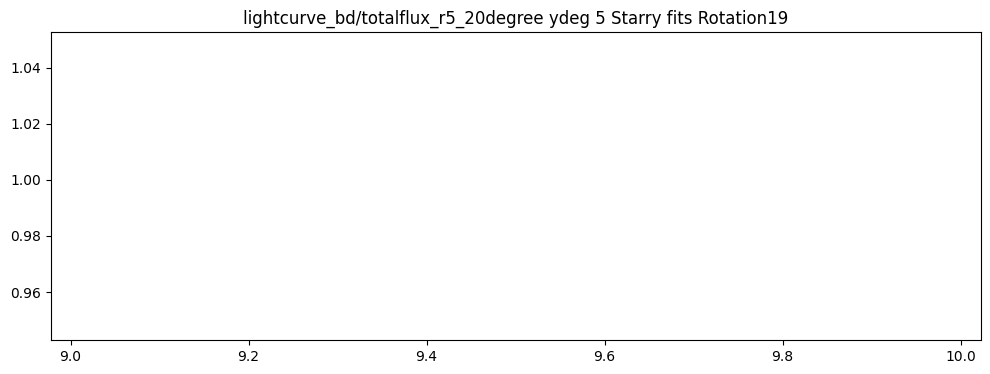

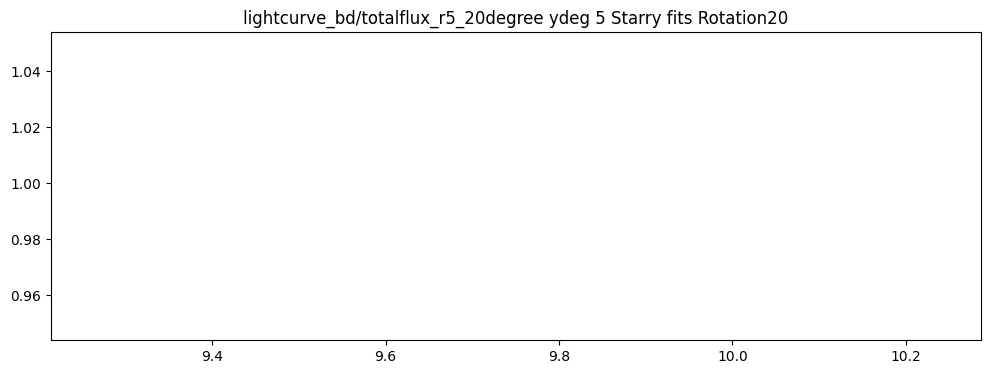

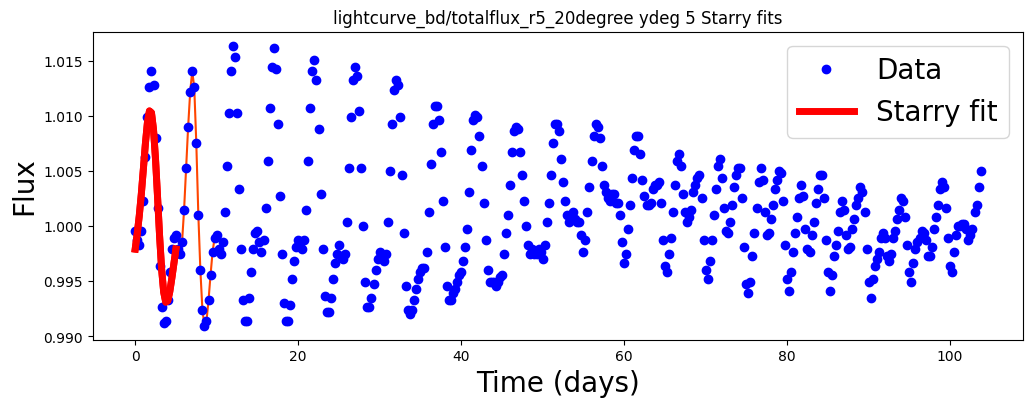

In [71]:
RotationSpliter(rotation_period,rotation_period_file,inc_angle,ydeg,filename)